In [31]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import librosa, librosa.display
import mir_eval
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (10, 3)

# Example: Two songs

- 장르 인식 전에, 다른 장르의 두 노래를 분류(classify)하고 성능을 보자.

    - 피쳐:
        - MFCC 12
    - 라벨:
        - 장르 (= 노래)
    - 훈련/테스트
        - train: 노래의 앞 30초
        - test: 노래의 120~130초

## data

In [2]:
fn_brahms = '../audio/brahms_hungarian_dance_5.mp3'
fn_busta = '../audio/busta_rhymes_hits_for_days.mp3'

x_brahms, sr_brahms = librosa.load(fn_brahms, duration=30)
x_busta, sr_busta = librosa.load(fn_busta, duration=30)

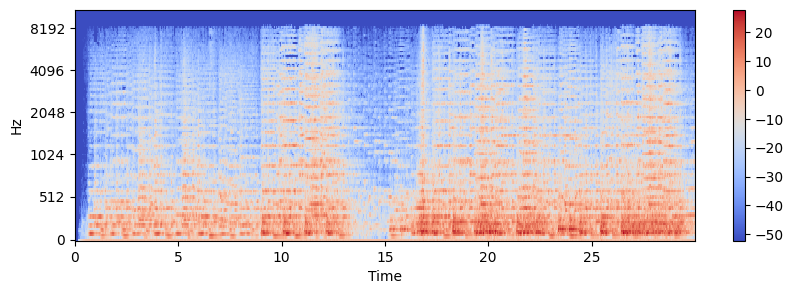

In [3]:
S_brahms = librosa.feature.melspectrogram(y=x_brahms, sr=sr_brahms, power=2.0)
Sdb_brahms = librosa.power_to_db(S_brahms)
librosa.display.specshow(Sdb_brahms, sr=sr_brahms, x_axis='time', y_axis='mel')
plt.colorbar()

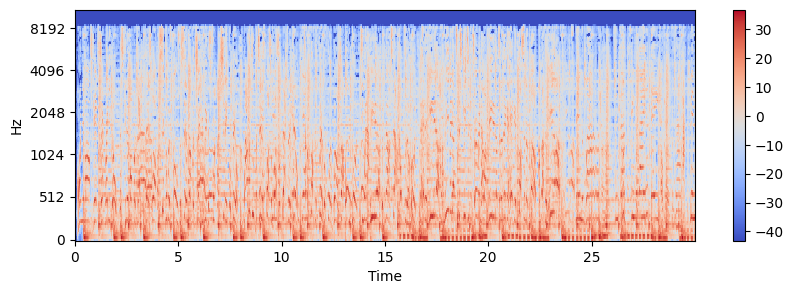

In [4]:
S_busta = librosa.feature.melspectrogram(y=x_busta, sr=sr_busta, power=2.0)
Sdb_busta = librosa.power_to_db(S_busta)
librosa.display.specshow(Sdb_busta, sr=sr_busta, x_axis='time', y_axis='mel')
plt.colorbar()

## features

In [5]:
n_mfcc = 12
mfcc_brahms = librosa.feature.mfcc(y=x_brahms, sr=sr_brahms, n_mfcc=n_mfcc).T
mfcc_busta = librosa.feature.mfcc(y=x_busta, sr=sr_busta, n_mfcc=n_mfcc).T

# scaler
scaler = StandardScaler()
mfcc_brahms_scaled = scaler.fit_transform(mfcc_brahms)
mfcc_busta_scaled = scaler.transform(mfcc_busta)

In [6]:
features = np.vstack((mfcc_brahms_scaled, mfcc_busta_scaled))
X = pd.DataFrame(features, columns=[f"MFCC {i}" for i in range(n_mfcc)])
X

,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7,MFCC 8,MFCC 9,MFCC 10,MFCC 11
0,-4.706408,-7.055327,1.121886,-5.379189,0.964453,-2.573732,1.212299,-1.166585,0.993131,-0.771122,0.662849,0.511190
1,-4.706408,-7.055327,1.121886,-5.379189,0.964453,-2.573732,1.212299,-1.166585,0.993131,-0.771122,0.662849,0.511190
2,-4.706408,-7.055327,1.121886,-5.379189,0.964453,-2.573732,1.212299,-1.166585,0.993131,-0.771122,0.662849,0.511190
3,-4.706408,-7.055327,1.121886,-5.379189,0.964453,-2.573732,1.212299,-1.166585,0.993131,-0.771122,0.662849,0.511190
4,-4.706408,-7.055327,1.121886,-5.379189,0.964453,-2.573732,1.212299,-1.166585,0.993131,-0.771122,0.662849,0.511190
...,...,...,...,...,...,...,...,...,...,...,...,...
2579,1.980801,-1.401790,0.327792,0.596022,0.076069,0.346499,-1.114038,1.836627,-1.340888,3.254128,-2.470369,2.073247
2580,1.561837,-1.955152,0.822870,0.961547,0.079051,-0.311918,-2.466828,1.275067,-1.561344,1.628710,-1.978704,2.120075
2581,1.111891,-2.081731,0.994028,0.696303,-0.080333,-1.111660,-2.479994,0.278059,-2.141018,0.319178,-2.317720,1.939381
2582,0.991603,-1.645633,0.142140,0.109385,0.648913,-1.210815,-1.499740,-0.331300,-2.084598,0.366533,-2.043514,1.271215


In [7]:
y = pd.Series(np.concatenate((np.zeros(len(mfcc_brahms_scaled)), np.ones(len(mfcc_busta_scaled)))))
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2579    1.0
2580    1.0
2581    1.0
2582    1.0
2583    1.0
Length: 2584, dtype: float64

## classifier

In [16]:
# model = RandomForestClassifier(n_estimators=100, max_depth=7)
model = SVC(C=1, gamma='scale')
model.fit(X, y)

SVC(C=1)

In [17]:
x_brahms_test, sr_brahms = librosa.load(fn_brahms, duration=10, offset=120)
x_busta_test, sr_busta = librosa.load(fn_busta, duration=10, offset=120)

mfcc_brahms_test = librosa.feature.mfcc(y=x_brahms_test, sr=sr_brahms, n_mfcc=n_mfcc).T
mfcc_busta_test = librosa.feature.mfcc(y=x_busta_test, sr=sr_busta, n_mfcc=n_mfcc).T

In [18]:
# use scaler used above
mfcc_brahms_test_scaled = scaler.transform(mfcc_brahms_test)
mfcc_busta_test_scaled = scaler.transform(mfcc_busta_test)

In [19]:
features_test = np.vstack((mfcc_brahms_test_scaled, mfcc_busta_test_scaled))
X_test = pd.DataFrame(features_test, columns=[f"MFCC {i}" for i in range(n_mfcc)])
y_true = pd.Series(np.concatenate((np.zeros(len(mfcc_brahms_test)), np.ones(len(mfcc_busta_test)))))

In [20]:
X_test

,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7,MFCC 8,MFCC 9,MFCC 10,MFCC 11
0,-0.065757,-1.059968,2.235551,-1.527394,2.475619,-1.486334,1.400040,-0.128244,1.911362,-0.579583,0.817576,-0.557862
1,0.012425,-0.634127,1.029488,-0.210428,1.605037,-1.220854,0.959791,-0.353272,1.728327,-0.590413,1.021759,0.388316
2,-0.113255,-0.105731,0.297513,0.180846,0.343080,-1.328612,1.285501,0.007788,1.573717,-0.930078,0.517926,-0.005442
3,-0.141667,-0.023116,-0.179416,0.039629,0.165399,-1.173013,1.725346,-0.015133,2.267050,-1.904512,0.768547,0.022504
4,-0.137920,-0.185528,-0.050437,-0.105913,0.257768,-1.165708,1.083625,-0.666044,1.611486,-1.158255,0.751400,0.732546
...,...,...,...,...,...,...,...,...,...,...,...,...
857,2.904374,-1.498137,-2.319513,0.597113,-2.934636,0.492067,-0.350674,2.840913,-1.144281,1.412410,-2.131343,2.174071
858,2.643650,-1.919359,-2.134540,-0.033360,-3.084756,-0.049036,-0.642088,2.512109,-1.488836,1.201380,-2.584390,1.362340
859,2.448428,-1.713121,-1.461000,-0.329695,-2.890340,-0.234447,-1.292194,1.928170,-1.503359,0.781548,-2.707137,1.047401
860,2.214176,-1.541747,-0.664618,-0.084330,-2.354411,-0.266462,-1.345443,1.157719,-1.637460,0.646100,-3.165366,1.663594


In [21]:
y_pred = model.predict(X_test)

## results

Accuracy:  0.9767981438515081
F1:  0.9773242630385488
ROC AUC:  0.9767981438515081


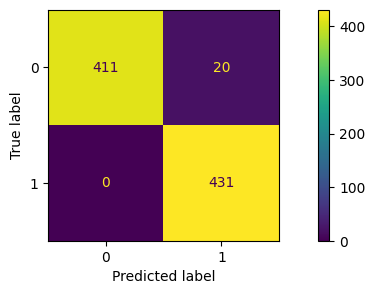

In [39]:
print('Accuracy: ', accuracy_score(y_true, y_pred))
print('F1: ', f1_score(y_true, y_pred))
print('ROC AUC: ', roc_auc_score(y_true, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()